# Principal Customers Graph

_Forget about your competitors, just focus on your customers_ - Jack Ma

Concepts:
- Supply chain
- Graph properties

References;
- Ling Cen and Sudipto Dasgupta, 2021, The Economics and Finance of Customer-Supplier Relationships


In [1]:
import math
import numpy as np
import pandas as pd
import networkx as nx
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL
from finds.recipes import graph_draw
from secret import credentials
import warnings
# %matplotlib qt
VERBOSE = 0
if not VERBOSE:
    warnings.simplefilter(action='ignore', category=FutureWarning)
sql = SQL(**credentials['sql'], verbose=VERBOSE)

## Supply chain

The interrelationships between upstream supplier firms and
downstream customer firms, referred to as “supply-chain”
relationships, constitute an important sources of linkages in the
economy.

### Principal customers


Regulation S-K and SFAS 131 require firms to disclose principal
customers that account for more than 10% of a firm’s total sales. An
important feature of these disclosure, however,
is that the suppliers are much smaller
than their corporate principal customers. The primary reason is that
customers are identified as "important" for the supplier in terms of
the percentage of the supplier's sales.

In [2]:
# retrieve principal customers info
year = 2016
cust = sql.read_dataframe(f"select gvkey, cgvkey, stic, ctic, conm, cconm "
                          f"  from customer "
                          f"    where srcdate >= {year}0101 "
                          f"      and srcdate <= {year}1231")

In [3]:
# construct Series to lookup company full name from ticker
lookup = pd.concat([Series(cust['conm'].values, cust['stic'].values),
                    Series(cust['cconm'].values, cust['ctic'].values)])\
           .drop_duplicates()

## Graph properties



In a __graph__, __nodes__ (also called vertices) represent entities or
objects, while __edges__ represent the connections or relationships
between these entities. The __degree__ of a graph is the number of edges 
that are directly connected to a particular node. 

__Density__ is the edges to nodes ratio: $\frac{2m}{n(n-1)}$ for undirected graphs,
and $\frac{m}{n(n-1)}$ for directed graphs, where $m$ is the number of edges and $n$ is the number of nodes


A __simple__ graph does not contain any self-loops (edges that connect a
vertex to itself) and does not have multiple edges between the same
pair of vertices.


A __subgraph__ is a subset of nodes within a larger graph, and including
only the edges that connect those selected nodes.
A __component__ of a graph is a subgraph where every node is connected to
every other node in the subgraph by some path

 


Attributes of graphs:
- weighted versus unweighted: whether there are any numerical values associated
  with each relationship (edge)
- directed versus undirected: whether the relationships (edges) explicitly require a
  a start and an end node
- cylic versus acylic: cyclic graphs contain at least one cycle,
  meaning there is a path that starts and ends at the same
  node. Acyclic graphs, on the other hand, do not have any cycles.
- connected versus disconnected: whether there is a path between any
  two nodes in graph, irrespective of distance
- Weakly connected
  components of a graph are sets of nodes where every pair of nodes
  has a path between them when ignoring the direction of edges.
  Strongly connected components are sets of
  nodes where every pair of nodes has a directed path between them.
- Weakly connected graphs have a path between every pair of nodes
  when considering the direction of edges, but ignoring their
  direction. Strongly connected graphs, on the other hand, have a
  directed path between every pair of nodes, considering the
  direction of edges.

In [4]:
# nodes are companies, with directed edges from supplier to customer
vertices = set(cust['stic']).union(cust['ctic'])
edges = cust[['stic', 'ctic']].values.tolist()  # supplier --> customer

In [5]:
# Populate networkx directed graph with nodes and edges
DG = nx.DiGraph()
DG.add_nodes_from(vertices)
DG.add_edges_from(edges)

In [6]:
# Helper to display graph properties
def graph_info(G):
    out = dict()
    out['is_directed'] = nx.is_directed(G)
    out['num_edges'] = nx.number_of_edges(G)
    out['num_nodes'] = nx.number_of_nodes(G)
    out['num_selfloops'] = nx.number_of_selfloops(G)
    out['density'] = nx.density(G)

    out['is_weighted'] = nx.is_weighted(G)
    if nx.is_weighted(G):
        out['is_negatively_weighted'] = nx.is_negatively_weighted(G)
    
    # Components
    if nx.is_directed(G):
        out['is_weakly_connected'] = nx.is_weakly_connected(G)
        out['weakly_connected_components'] = nx.number_weakly_connected_components(G)
        out['size_largest_weak_component'] = len(max(
            nx.weakly_connected_components(G), key=len))
        out['is_strongly_connected'] = nx.is_strongly_connected(G)
        out['strongly_connected_components'] = nx.number_strongly_connected_components(G)
        out['size_largest_strong_component'] = len(max(
            nx.strongly_connected_components(G), key=len))
    else:
        out['is_connected'] = nx.is_connected(G)
        out['connected_components'] = nx.number_connected_components(G)
        out['size_largest_component'] = len(max(
            nx.connected_components(G), key=len))
    return out

In [7]:
Series(graph_info(DG)).rename('Principal Customers Graph').to_frame()

,Principal Customers Graph
is_directed,True
num_edges,3052
num_nodes,1830
num_selfloops,11
density,0.000912
is_weighted,False
is_weakly_connected,False
weakly_connected_components,89
size_largest_weak_component,1628
is_strongly_connected,False


In [8]:
# remove self-loops, if any
DG.remove_edges_from(nx.selfloop_edges(DG))

### Clustering coefficient

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together.

- a __triplet__ is three nodes that are connected by either two (open triplet) or three (closed triplet) undirected ties. 
- a __triangle__ comprises three closed triplets, one centered on each of the nodes
- the __clustering coefficient__ of a node is the fraction of possible traingles through that node that exist $\frac{2\mathrm{\#triangles}}{(\mathrm{degree})(\mathrm{degree}-1)}$
- __graph transitivity__ is the fraction of all possible triangles present $ 3 \frac{\mathrm{\# triangles}}{\mathrm{\#triads}}$ where possible triangles are identified by the number of __triads__ (two edges with a shared vertex).

In [9]:
# as an undirected graph
G = nx.Graph(DG)
DataFrame({'transitivity': nx.transitivity(G),
           'average clustering': nx.average_clustering(G)},
          index=['clustering'])

,transitivity,average clustering
clustering,0.005751,0.009872


### Degree analysis

In directed graphs, the __out degree__ is the number of edges pointing out of the node, while the __in degree__ is the number of edges pointing in.


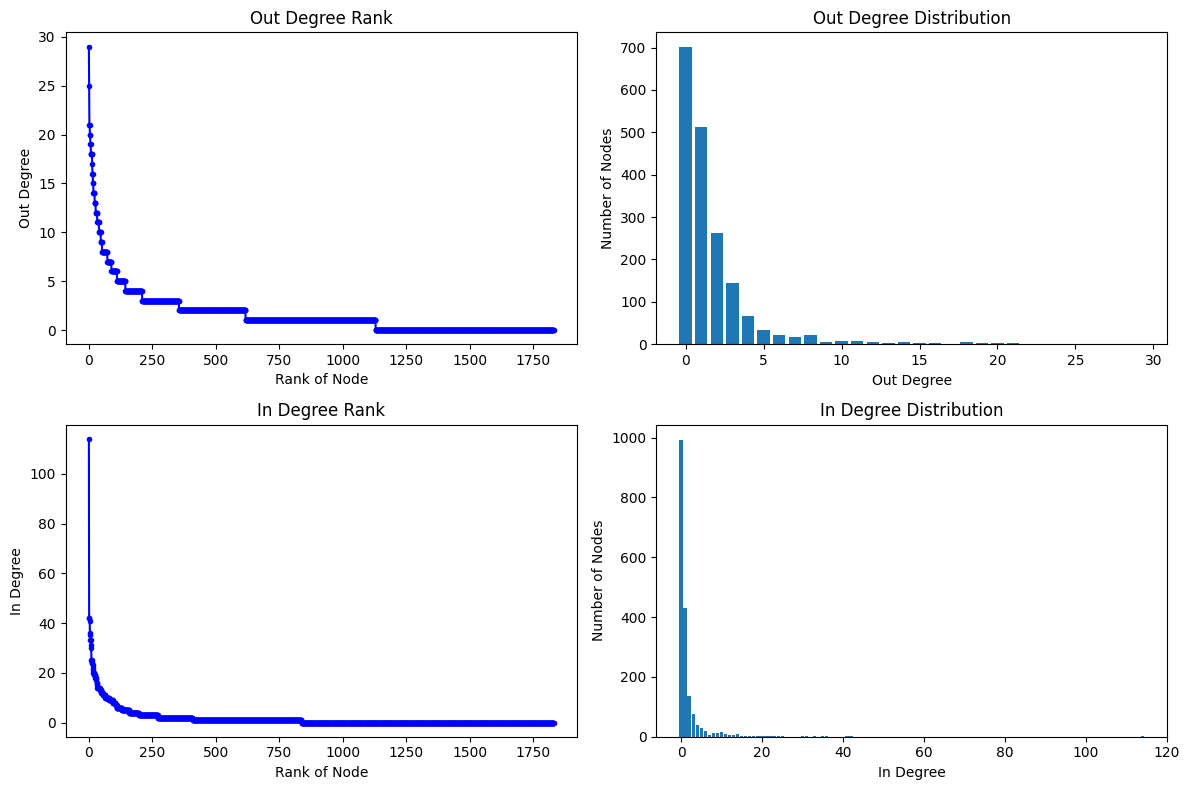

In [10]:
# Plot distribution of degrees
degrees = {'Out Degree': sorted((d for n, d in DG.out_degree()), reverse=True),
           'In Degree': sorted((d for n, d in DG.in_degree()), reverse=True)}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for ax, direction in zip(axes, degrees):
    ax[0].plot(degrees[direction], "b-", marker=".")
    ax[0].set_title(f"{direction} Rank")
    ax[0].set_ylabel(f"{direction}")
    ax[0].set_xlabel("Rank of Node")
    ax[1].bar(*np.unique(degrees[direction], return_counts=True))
    ax[1].set_title(f"{direction} Distribution")
    ax[1].set_xlabel(f"{direction}")
    ax[1].set_ylabel("Number of Nodes")
plt.tight_layout()
plt.show()

### Ego network

__Ego__ is some individual focal node.  A network can have as many
egos as it has nodes. __Neighborhood__ is the collection of ego and
all nodes to whom ego has a connection at some path length.  The
neighborhood is usually one-step; that is, it includes only ego and
nodes that are directly adjacent.  The neighborhood also includes
all of the edges among all of the actors to whom ego has a direct
connection.

In [11]:
# find node with greatest degree
(ego, degree) = max(G.degree(), key=lambda x: x[1])

# build subgraph of ego and neighbors
all_neighbors = list(nx.all_neighbors(DG, ego))  # predecessors and successors
neighbors = list(nx.neighbors(DG, ego))          # successors only
ego_graph = DG.subgraph([ego] + all_neighbors).copy()

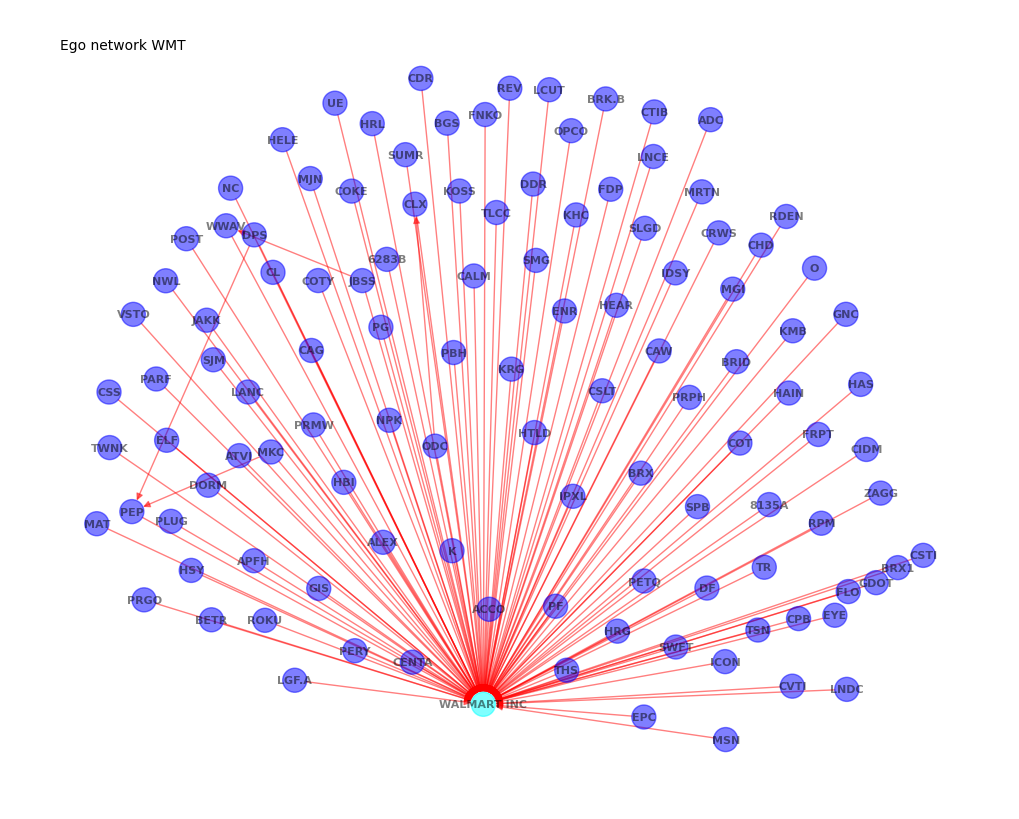

In [12]:
# Plot ego graph
node_color = (dict.fromkeys(all_neighbors, 'b')
              | dict.fromkeys(neighbors, 'g')
              | {ego: 'cyan'})

labels = ({ticker: ticker for ticker in ego_graph.nodes}
          | {ticker: lookup[ticker] for ticker in [ego] + neighbors})

graph_draw(ego_graph, figsize=(10, 8), node_size=300, seed=42, 
           width=1, node_color=node_color, labels=labels, style='-',
           title=f"Ego network {ego}") 
plt.show()

### Path lengths

The __distance__ or __path length__ between two nodes is the shortest path
(fewest number of edges) required to travel from one to the other.

The __eccentricity__ of a node is the maximum distance from the to
all other nodes in a graph.  __Diameter__ is the maximum eccentricity over
all nodes in the graph.



In [13]:
# find component with the longest diameter
components = list(nx.weakly_connected_components(DG))
nodes = components[np.argmax([nx.diameter(G.subgraph(c)) for c in components])]

In [14]:
# compute all shortest path lengths, and determine the longest
best_length = 0
for src, targets in dict(nx.shortest_path(G.subgraph(nodes))).items():
    for tgt, path in targets.items():
        length = len(path)
        if length > best_length:
            best_length = length
            best_path = path

{'TOL': (5.0, 0.0),
 'BMCH': (3.2418138352088386, 5.048825908847379),
 'HOV': (-2.9130278558299967, 6.365081987779772),
 'BLDR': (-7.919939972803563, 1.1289600644789377),
 'BCC': (-5.882792587772507, -6.811222457771354),
 'HD': (2.8366218546322624, -9.589242746631385),
 'TRNO': (10.561873153154025, -3.0735704801881845),
 'FDX': (9.046827052119655, 7.883839184625469),
 'SIR': (-1.8915004395119759, 12.861657206103963),
 'ALL': (-12.755823666385478, 5.769658793384592),
 'CLI': (-12.586072936146786, -8.160316663340547),
 'BG': (0.07081116780881257, -15.999843304811256),
 'CZZ': (14.345517298452366, -9.121739606007393),
 'ADM': (16.33404206610353, 7.563006662879537),
 'REX': (2.5980071459488383, 18.821539758202537),
 '9919B': (-15.193758257176427, 13.005756803142337),
 'CF': (-20.110849086791077, -6.045969649966372)}

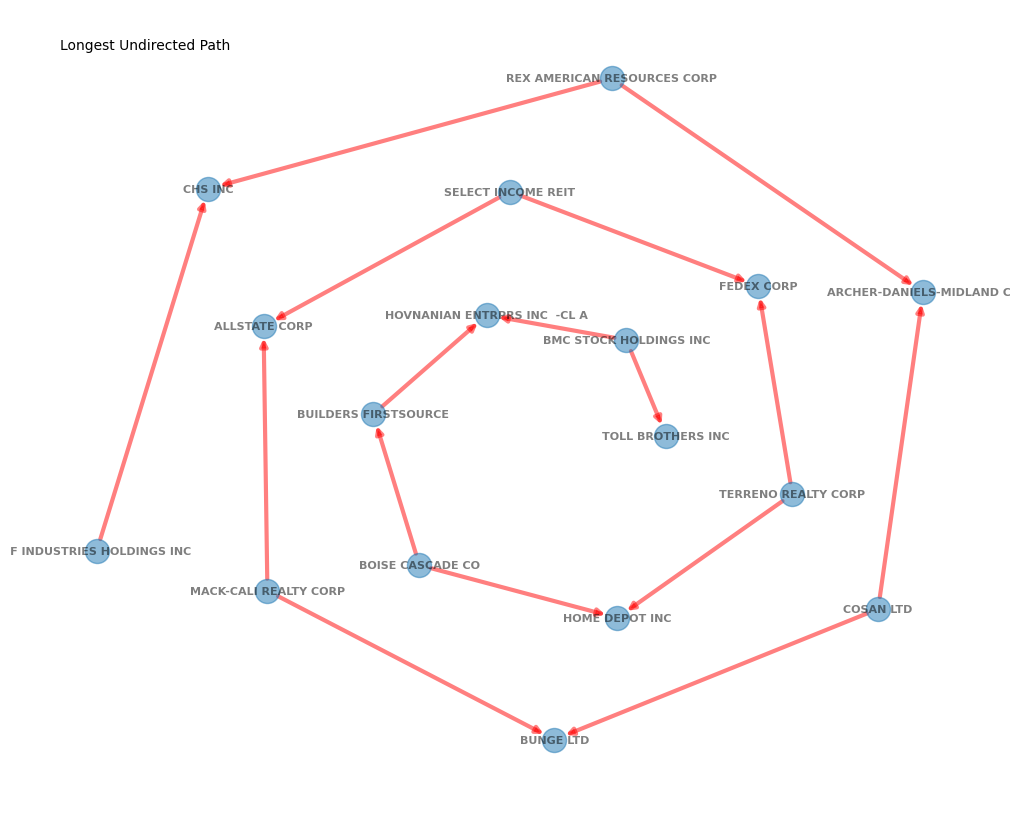

In [15]:
# Archimedean spiral: r = b theta
pos = {ticker: ((n + 5) * math.cos(n), (n + 5) * math.sin(n))
       for n, ticker in enumerate(best_path)}

# Plot nodes in a spiral graph
labels = {ticker: lookup[ticker] for ticker in best_path}
graph_draw(DG.subgraph(best_path), figsize=(10, 8), node_size=300,
           width=3, labels=labels, style='-',  pos=pos,
           title=f"Longest Undirected Path") 